This is a companion notebook for the book [Deep Learning with Python, Third Edition](https://www.manning.com/books/deep-learning-with-python-third-edition). For readability, it only contains runnable code blocks and section titles, and omits everything else in the book: text paragraphs, figures, and pseudocode.

**If you want to be able to follow what's going on, I recommend reading the notebook side by side with your copy of the book.**

The book's contents are available online at [deeplearningwithpython.io](https://deeplearningwithpython.io).

In [77]:
!pip install keras keras-hub --upgrade -q

In [78]:
import os
os.environ["KERAS_BACKEND"] = "jax"

In [79]:
# @title
import os
from IPython.core.magic import register_cell_magic

@register_cell_magic
def backend(line, cell):
    current, required = os.environ.get("KERAS_BACKEND", ""), line.split()[-1]
    if current == required:
        get_ipython().run_cell(cell)
    else:
        print(
            f"This cell requires the {required} backend. To run it, change KERAS_BACKEND to "
            f"\"{required}\" at the top of the notebook, restart the runtime, and rerun the notebook."
        )

## A deep dive on Keras

이 장에서는 다음 내용을 다룹니다.

* Keras 모델을 생성하는 다양한 방법: Sequential 클래스, Functional API 및 모델 서브클래싱
* 내장된 Keras 학습 및 평가 루프 사용 방법(사용자 지정 메트릭 및 손실 함수 사용 방법 포함)
* Keras 콜백을 사용하여 학습 진행 방식을 더욱 세밀하게 사용자 지정하는 방법
* TensorBoard를 사용하여 학습 및 평가 메트릭을 시간에 따라 모니터링하는 방법
* 학습 및 평가 루프를 처음부터 직접 작

이제 Keras를 어느 정도 경험해 보셨을 겁니다. Sequential 모델, Dense 레이어, 그리고 학습, 평가, 추론을 위한 내장 API(compile(), fit(), evaluate(), predict())에 익숙해지셨을 것입니다. 3장에서는 Layer 클래스를 상속받아 사용자 정의 레이어를 만드는 방법과 TensorFlow, JAX, PyTorch의 그래디언트 API를 사용하여 단계별 학습 루프를 구현하는 방법도 배웠습니다.

다음 장에서는 컴퓨터 비전, 시계열 예측, 자연어 처리, 생성형 딥러닝을 자세히 살펴보겠습니다. 이러한 복잡한 애플리케이션을 구현하려면 Sequential 아키텍처와 기본 fit() 루프만으로는 부족합니다. 그러니 먼저 여러분을 Keras 전문가로 만들어 봅시다! 이 장에서는 Keras API를 사용하는 핵심적인 방법들을 완벽하게 개괄적으로 살펴보겠습니다. 앞으로 접하게 될 고급 딥러닝 사용 사례들을 처리하는 데 필요한 모든 것을 배우게 될 것입니다.성하는 방법

### A spectrum of workflows

케라스 API의 설계는 복잡성의 점진적 공개라는 원칙에 따라 이루어졌습니다. 즉, 쉽게 시작할 수 있도록 하면서도, 각 단계에서 점진적인 학습만으로 복잡한 사용 사례도 처리할 수 있도록 하는 것입니다. 간단한 사용 사례는 쉽고 접근하기 쉬워야 하며, 고급 워크플로도 가능해야 합니다. 아무리 전문적이고 복잡한 작업을 수행하더라도, 그 목표에 도달하는 명확한 경로가 있어야 하며, 이 경로는 간단한 워크플로에서 학습한 다양한 요소들을 기반으로 구축되어야 합니다. 이는 초보자에서 전문가로 성장하더라도 동일한 도구를 다양한 방식으로 사용할 수 있음을 의미합니다.

따라서 케라스를 사용하는 단 하나의 "정답"은 없습니다. 케라스는 매우 간단한 워크플로부터 매우 유연한 워크플로까지 다양한 워크플로를 제공합니다. 케라스 모델을 구축하는 방법과 학습시키는 방법 또한 다양하며, 각각 다른 요구 사항을 충족합니다.

예를 들어, 모델을 구축하는 다양한 방법과 학습시키는 다양한 방법이 있으며, 각 방법은 사용 편의성과 유연성 사이의 특정 절충점을 나타냅니다. 케라스를 마치 scikit-learn처럼 `fit()` 메서드만 호출하고 프레임워크가 알아서 처리하도록 둘 수도 있고, NumPy처럼 모든 세부 사항을 직접 제어하며 사용할 수도 있습니다.

이러한 워크플로는 모두 `Layer`와 `Model` 같은 공유 API를 기반으로 하기 때문에 어떤 워크플로의 구성 요소든 다른 워크플로에서 사용할 수 있습니다. 즉, 모든 워크플로가 서로 연동됩니다. 따라서 지금 배우는 모든 내용은 전문가가 된 후에도 여전히 유용합니다. 쉽게 시작해서 점차 더 복잡한 로직을 직접 작성하는 워크플로로 나아갈 수 있습니다. 학생에서 연구원으로, 또는 데이터 과학자에서 딥러닝 엔지니어로 성장한다고 해서 완전히 다른 프레임워크로 갈아탈 필요가 없습니다.

이러한 철학은 파이썬 자체의 철학과도 같습니다! 어떤 언어는 객체 지향 프로그래밍이나 함수형 프로그래밍처럼 프로그램을 작성하는 한 가지 방법만 제공합니다. 하지만 파이썬은 다양한 패러다임을 지원하는 언어입니다. 다양한 사용 패턴을 제공하며, 이 패턴들은 서로 조화롭게 작동합니다. 이러한 특징 덕분에 파이썬은 시스템 관리, 데이터 과학, 머신러닝 엔지니어링, 웹 개발, 심지어 프로그래밍 학습에 이르기까지 매우 다양한 용도에 적합합니다. 마찬가지로 케라스는 딥러닝 분야의 파이썬이라고 생각할 수 있습니다. 사용자 친화적인 딥러닝 언어로서 다양한 사용자 프로필에 맞는 여러 워크플로우를 제공합니다.

### Different ways to build Keras models
그림 7.1에서 보는 것처럼 Keras에서 모델을 구축하는 데에는 세 가지 API가 있습니다.

Sequential 모델은 가장 접근하기 쉬운 API로, 기본적으로 파이썬 리스트와 같습니다. 따라서 간단한 레이어 스택으로 제한됩니다.
Functional API는 그래프 형태의 모델 아키텍처에 초점을 맞춥니다. 사용성과 유연성의 균형을 잘 맞춰주기 때문에 가장 일반적으로 사용되는 모델 구축 API입니다.
모델 서브클래싱은 모든 것을 처음부터 직접 작성하는 저수준 옵션입니다. 모든 세부 사항을 완벽하게 제어하고 싶을 때 이상적입니다. 하지만 Keras의 내장 기능을 많이 사용할 수 없고, 오류 발생 위험도 더 높습니다.

<img src="https://deeplearningwithpython.io/images/ch07/progressive_disclosure_of_complexity_models.f43bcdb0.png" width="600"><p style="text-align:center">Figure 7.1: Progressive disclosure of complexity for model building</p>


#### The Sequential model

케라스 모델을 구축하는 가장 간단한 방법은 여러분이 이미 알고 있는 Sequential 모델입니다.

In [1]:
import keras
from keras import layers

model = keras.Sequential(
    [
        layers.Dense(64, activation="relu"),
        layers.Dense(10, activation="softmax"),
    ]
)

파이썬 리스트의 append() 메서드와 유사하게 add() 메서드를 통해 동일한 모델을 점진적으로 구축할 수 있다는 점에 유의하십시오.

In [3]:
model = keras.Sequential()
model.add(layers.Dense(64, activation="relu"))
model.add(layers.Dense(10, activation="softmax"))

3장에서 보셨듯이 레이어는 처음 호출될 때만 생성(즉, 가중치 생성)됩니다. 이는 레이어 가중치의 형태가 입력의 형태에 따라 달라지기 때문입니다. 입력 형태를 알기 전까지는 가중치를 생성할 수 없습니다.

따라서 앞서 살펴본 Sequential 모델은 실제로 데이터를 사용하여 호출하거나, 입력 형태를 지정하여 `build()` 메서드를 호출하기 전까지는 가중치를 갖지 않습니다.

In [5]:
model.weights

[]

In [6]:
# Builds the model. Now the model will expect samples of shape
# (3,). The None in the input shape signals that the batch size
# could be anything.
model.build(input_shape=(None, 3))
# Now you can retrieve the model's weights.
model.weights

[<Variable path=sequential_1/dense_2/kernel, shape=(3, 64), dtype=float32, value=[[ 2.54702926e-01  7.62956440e-02  6.15263879e-02  2.37277746e-01
    7.42867887e-02  1.50711179e-01  1.09444380e-01  4.88079786e-02
   -1.55318573e-01 -2.77410001e-01 -1.70827582e-01 -2.98092335e-01
    4.46355343e-03 -5.81276119e-02 -1.00441575e-02 -1.86474070e-01
   -1.25022665e-01  2.13086724e-01 -1.83776617e-02  7.35586882e-02
   -1.22972935e-01  2.87660658e-02 -1.74186468e-01  1.43654346e-01
   -5.75728863e-02 -2.72414684e-01 -2.02964038e-01  6.79664910e-02
    1.52969182e-01  1.13277525e-01 -2.25347579e-01  2.47009695e-01
    2.45648623e-03 -1.61507323e-01  2.95137823e-01 -2.88452506e-01
    1.33629084e-01 -1.22874185e-01 -1.78508908e-01 -1.43452361e-01
    9.35935974e-03 -9.60451961e-02  8.78291726e-02 -1.78415656e-01
    1.54769987e-01 -5.08776307e-02  1.87758684e-01 -1.67139128e-01
    2.50300705e-01 -1.61230713e-01  3.81367803e-02 -3.80921662e-02
   -1.70105100e-02 -2.13105142e-01 -4.29670513e-0

모델 구축이 완료되면 summary() 메서드를 통해 모델의 내용을 표시할 수 있으며, 이는 디버깅에 유용합니다.

In [8]:
model.summary(line_length=80)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                      ┃ Output Shape             ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_2 (Dense)                   │ (None, 64)               │           256 │
├───────────────────────────────────┼──────────────────────────┼───────────────┤
│ dense_3 (Dense)                   │ (None, 10)               │           650 │
└───────────────────────────────────┴──────────────────────────┴───────────────┘

 Total params: 906 (3.54 KB)

 Trainable params: 906 (3.54 KB)

 Non-trainable params: 0 (0.00 B)

보시다시피, 모델 이름이 sequential_1로 지정되었습니다. 케라스에서는 모델, 레이어 등 모든 것에 이름을 지정할 수 있습니다.

In [10]:
model = keras.Sequential(name="my_example_model")
model.add(layers.Dense(64, activation="relu", name="my_first_layer"))
model.add(layers.Dense(10, activation="softmax", name="my_last_layer"))
model.build((None, 3))
model.summary(line_length=80)

Model: "my_example_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                      ┃ Output Shape             ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ my_first_layer (Dense)            │ (None, 64)               │           256 │
├───────────────────────────────────┼──────────────────────────┼───────────────┤
│ my_last_layer (Dense)             │ (None, 10)               │           650 │
└───────────────────────────────────┴──────────────────────────┴───────────────┘

 Total params: 906 (3.54 KB)

 Trainable params: 906 (3.54 KB)

 Non-trainable params: 0 (0.00 B)

Sequential 모델을 점진적으로 구축할 때, 각 레이어를 추가한 후 현재 모델의 모습을 요약해서 출력하는 것이 유용합니다. 하지만 모델 구축이 완료되기 전까지는 요약 출력을 할 수 없습니다! 사실, Sequential 모델을 동적으로 구축하는 방법이 있습니다. 바로 모델 입력의 형태를 미리 선언하는 것입니다. Input 클래스를 통해 이를 구현할 수 있습니다.

In [12]:
model = keras.Sequential()
# Use an Input to declare the shape of the inputs. Note that the shape
# argument must be the shape of each sample, not the shape of one
# batch.
model.add(keras.Input(shape=(3,)))
model.add(layers.Dense(64, activation="relu"))

이제 summary() 함수를 사용하여 레이어를 추가함에 따라 모델의 출력 형태가 어떻게 변하는지 확인할 수 있습니다.

In [14]:
model.summary(line_length=80)

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                      ┃ Output Shape             ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                   │ (None, 64)               │           256 │
└───────────────────────────────────┴──────────────────────────┴───────────────┘

 Total params: 256 (1.00 KB)

 Trainable params: 256 (1.00 KB)

 Non-trainable params: 0 (0.00 B)

In [15]:
model.add(layers.Dense(10, activation="softmax"))
model.summary(line_length=80)

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                      ┃ Output Shape             ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                   │ (None, 64)               │           256 │
├───────────────────────────────────┼──────────────────────────┼───────────────┤
│ dense_5 (Dense)                   │ (None, 10)               │           650 │
└───────────────────────────────────┴──────────────────────────┴───────────────┘

 Total params: 906 (3.54 KB)

 Trainable params: 906 (3.54 KB)

 Non-trainable params: 0 (0.00 B)

이는 8장에서 배우게 될 컨볼루션 레이어처럼 입력값을 복잡한 방식으로 변환하는 레이어를 다룰 때 흔히 사용하는 디버깅 워크플로입니다.

#### The Functional API

Sequential 모델은 사용하기 쉽지만 적용 범위가 매우 제한적입니다. 단일 입력과 단일 출력을 가진 모델만 표현할 수 있으며, 레이어를 순차적으로 적용하는 방식만 가능합니다. 하지만 실제로는 여러 입력(예: 이미지와 메타데이터), 여러 출력(데이터에 대해 예측하고자 하는 다양한 값), 또는 비선형 토폴로지를 가진 모델을 흔히 접하게 됩니다.

이러한 경우에는 Functional API를 사용하여 모델을 구축합니다. 대부분의 Keras 모델은 이 Functional API를 사용합니다. 마치 레고 블록을 가지고 노는 것처럼 재미있고 강력한 기능을 제공합니다.

##### A simple example

간단한 것부터 시작해 보겠습니다. 이전 섹션에서 사용했던 2계층 스택입니다. 해당 스택의 함수형 API 버전은 다음과 같습니다.

In [19]:
inputs = keras.Input(shape=(3,), name="my_input")
features = layers.Dense(64, activation="relu")(inputs)
outputs = layers.Dense(10, activation="softmax")(features)
model = keras.Model(inputs=inputs, outputs=outputs, name="my_functional_model")

단계별로 살펴보겠습니다. 먼저 Input 객체를 선언했습니다(다른 모든 객체와 마찬가지로 Input 객체에도 이름을 지정할 수 있습니다).

In [21]:
inputs = keras.Input(shape=(3,), name="my_input")

이 입력 객체는 모델이 처리할 데이터의 형태와 데이터 유형에 대한 정보를 담고 있습니다.

In [23]:
# The model will process batches where each sample has shape (3,).
# The number of samples per batch is variable (indicated by the
# None batch size).
inputs.shape

(None, 3)

In [24]:
# These batches will have dtype float32.
inputs.dtype

'float32'

우리는 이러한 객체를 심볼릭 텐서라고 부릅니다. 심볼릭 텐서 자체는 실제 데이터를 포함하지 않지만, 모델을 사용할 때 모델이 보게 될 실제 데이터 텐서의 명세를 인코딩합니다. 이는 미래의 데이터 텐서를 의미합니다.

다음으로, 레이어를 생성하고 입력에 대해 호출했습니다.

In [26]:
features = layers.Dense(64, activation="relu")(inputs)

모든 Keras 레이어는 실제 데이터 텐서 또는 기호 텐서 모두에서 호출할 수 있습니다. 후자의 경우, 업데이트된 모양과 데이터 유형 정보를 포함하는 새로운 기호 텐서를 반환합니다.

In [28]:
features.shape

(None, 64)

최종 결과를 얻은 후, 모델 생성자에서 입력과 출력을 지정하여 모델을 인스턴스화했습니다.

In [30]:
outputs = layers.Dense(10, activation="softmax")(features)
model = keras.Model(inputs=inputs, outputs=outputs, name="my_functional_model")

다음은 저희 모델의 요약입니다.

In [32]:
model.summary(line_length=80)

Model: "my_functional_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                      ┃ Output Shape             ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ my_input (InputLayer)             │ (None, 3)                │             0 │
├───────────────────────────────────┼──────────────────────────┼───────────────┤
│ dense_8 (Dense)                   │ (None, 64)               │           256 │
├───────────────────────────────────┼──────────────────────────┼───────────────┤
│ dense_9 (Dense)                   │ (None, 10)               │           650 │
└───────────────────────────────────┴──────────────────────────┴───────────────┘

 Total params: 906 (3.54 KB)

 Trainable params: 906 (3.54 KB)

 Non-trainable params: 0 (0.00 B)

##### Multi-input, multi-output models

이 간단한 모델과 달리 대부분의 딥러닝 모델은 리스트 형태가 아니라 그래프 형태를 띕니다. 예를 들어, 여러 개의 입력이나 여러 개의 출력을 가질 수 있습니다. 함수형 API는 바로 이러한 유형의 모델에서 진가를 발휘합니다.

고객 지원 티켓을 우선순위에 따라 순위를 매기고 적절한 부서로 배정하는 시스템을 구축한다고 가정해 보겠습니다. 모델에는 세 가지 입력이 있습니다.

* 티켓 제목(텍스트 입력)
* 티켓 본문(텍스트 입력)
* 사용자가 추가한 태그(범주형 입력, 여기서는 멀티핫 인코딩되었다고 가정)

텍스트 입력은 vocabulary_size 크기의 1과 0으로 이루어진 배열로 인코딩할 수 있습니다(텍스트 인코딩 기법에 대한 자세한 내용은 14장을 참조하세요).

모델에는 두 가지 출력도 있습니다.

* 티켓의 우선순위 점수(0에서 1 사이의 스칼라 값, 시그모이드 함수)
* 티켓을 처리해야 하는 부서(부서 집합에 대한 소프트맥스 함수)

함수형 API를 사용하면 몇 줄의 코드로 이 모델을 구축할 수 있습니다.

In [34]:
vocabulary_size = 10000
num_tags = 100
num_departments = 4

title = keras.Input(shape=(vocabulary_size,), name="title")
text_body = keras.Input(shape=(vocabulary_size,), name="text_body")
tags = keras.Input(shape=(num_tags,), name="tags")

features = layers.Concatenate()([title, text_body, tags])
features = layers.Dense(64, activation="relu", name="dense_features")(features)

priority = layers.Dense(1, activation="sigmoid", name="priority")(features)
department = layers.Dense(
    num_departments, activation="softmax", name="department"
)(features)

model = keras.Model(
    inputs=[title, text_body, tags],
    outputs=[priority, department],
)

함수형 API는 레고처럼 간단하면서도 매우 유연한 방식으로 이러한 계층 구조의 임의 그래프를 정의할 수 있는 방법입니다.

##### Training a multi-input, multi-output model

Sequential 모델을 학습시키는 것과 거의 같은 방식으로, 입력 및 출력 데이터 목록을 사용하여 fit() 메서드를 호출함으로써 모델을 학습시킬 수 있습니다. 이러한 데이터 목록은 Model() 생성자에 전달한 입력 순서와 동일해야 합니다.

In [37]:
import numpy as np

num_samples = 1280

title_data = np.random.randint(0, 2, size=(num_samples, vocabulary_size))
text_body_data = np.random.randint(0, 2, size=(num_samples, vocabulary_size))
tags_data = np.random.randint(0, 2, size=(num_samples, num_tags))

priority_data = np.random.random(size=(num_samples, 1))
department_data = np.random.randint(0, num_departments, size=(num_samples, 1))

model.compile(
    optimizer="adam",
    loss=["mean_squared_error", "sparse_categorical_crossentropy"],
    metrics=[["mean_absolute_error"], ["accuracy"]],
)
model.fit(
    [title_data, text_body_data, tags_data],
    [priority_data, department_data],
    epochs=1,
)
model.evaluate(
    [title_data, text_body_data, tags_data], [priority_data, department_data]
)
priority_preds, department_preds = model.predict(
    [title_data, text_body_data, tags_data]
)

40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - department_accuracy: 0.2492 - department_loss: 3.1815 - loss: 3.4182 - priority_loss: 0.2368 - priority_mean_absolute_error: 0.4041
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - department_accuracy: 0.2672 - department_loss: 1.3567 - loss: 1.4378 - priority_loss: 0.0811 - priority_mean_absolute_error: 0.2468
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


입력 순서에 의존하고 싶지 않은 경우(예: 입력이나 출력이 많은 경우) 입력 객체와 출력 레이어에 지정한 이름을 사용하여 딕셔너리를 통해 데이터를 전달할 수도 있습니다.

In [39]:
model.compile(
    optimizer="adam",
    loss={
        "priority": "mean_squared_error",
        "department": "sparse_categorical_crossentropy",
    },
    metrics={
        "priority": ["mean_absolute_error"],
        "department": ["accuracy"],
    },
)
model.fit(
    {"title": title_data, "text_body": text_body_data, "tags": tags_data},
    {"priority": priority_data, "department": department_data},
    epochs=1,
)
model.evaluate(
    {"title": title_data, "text_body": text_body_data, "tags": tags_data},
    {"priority": priority_data, "department": department_data},
)
priority_preds, department_preds = model.predict(
    {"title": title_data, "text_body": text_body_data, "tags": tags_data}
)

40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - department_accuracy: 0.2594 - department_loss: 1.3875 - loss: 1.4687 - priority_loss: 0.0812 - priority_mean_absolute_error: 0.2451
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - department_accuracy: 0.2562 - department_loss: 1.3843 - loss: 1.4654 - priority_loss: 0.0811 - priority_mean_absolute_error: 0.2470
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


##### The power of the Functional API: Access to layer connectivity

함수형 모델은 명시적인 그래프 데이터 구조입니다. 이를 통해 레이어 간의 연결 방식을 살펴보고 이전 그래프 노드(레이어 출력)를 새로운 모델의 일부로 재사용할 수 있습니다. 또한 대부분의 연구자들이 심층 신경망을 생각할 때 떠올리는 "레이어 그래프"라는 "정신적 모델"과도 잘 맞아떨어집니다.

이러한 특징은 모델 시각화와 특징 추출이라는 두 가지 중요한 활용 사례를 가능하게 합니다. 이제 자세히 살펴보겠습니다.

###### Plotting layer connectivity

방금 정의한 모델의 연결성(모델의 토폴로지)을 시각화해 보겠습니다. 그림 7.2에서처럼 plot_model() 유틸리티를 사용하여 함수형 모델을 그래프로 나타낼 수 있습니다.

In [42]:
keras.utils.plot_model(model, "ticket_classifier.png")

You must install graphviz (see instructions at https://graphviz.gitlab.io/download/) for `plot_model` to work.


이 그래프에는 모델의 각 레이어의 입력 및 출력 형태와 레이어 이름(레이어 유형뿐 아니라)도 추가할 수 있으며, 이는 디버깅 중에 유용할 수 있습니다(그림 7.3).

In [44]:
keras.utils.plot_model(
    model,
    "ticket_classifier_with_shape_info.png",
    show_shapes=True,
    show_layer_names=True,
)

You must install graphviz (see instructions at https://graphviz.gitlab.io/download/) for `plot_model` to work.


텐서 형태의 None은 배치 크기를 나타냅니다. 이 모델은 임의의 크기의 배치를 허용합니다.

###### Feature extraction with a Functional model

레이어 연결에 접근할 수 있다는 것은 그래프에서 개별 노드(레이어 호출)를 검사하고 재사용할 수 있음을 의미합니다. 모델 속성 `model.layers`는 모델을 구성하는 레이어 목록을 제공하며, 각 레이어에 대해 `layer.input`과 `layer.output`을 쿼리할 수 있습니다.

In [47]:
model.layers

[<InputLayer name=title, built=True>,
 <InputLayer name=text_body, built=True>,
 <InputLayer name=tags, built=True>,
 <Concatenate name=concatenate, built=True>,
 <Dense name=dense_features, built=True>,
 <Dense name=priority, built=True>,
 <Dense name=department, built=True>]

In [48]:
model.layers[3].input

[<KerasTensor shape=(None, 10000), dtype=float32, sparse=False, ragged=False, name=title>,
 <KerasTensor shape=(None, 10000), dtype=float32, sparse=False, ragged=False, name=text_body>,
 <KerasTensor shape=(None, 100), dtype=float32, sparse=False, ragged=False, name=tags>]

In [49]:
model.layers[3].output

<KerasTensor shape=(None, 20100), dtype=float32, sparse=False, ragged=False, name=keras_tensor_14>

이를 통해 특징 추출, 즉 다른 모델의 중간 특징을 재사용하는 모델을 만들 수 있습니다.

예를 들어, 이전에 정의한 모델에 또 다른 출력을 추가하고 싶다고 가정해 보겠습니다. 특정 이슈 티켓이 해결되는 데 걸리는 시간을 예측하는 기능, 즉 난이도 등급을 추가하고 싶다고 해봅시다. 이 경우 "빠름", "중간", "어려움"의 세 가지 범주로 분류하는 레이어를 사용할 수 있습니다. 처음부터 모델을 다시 만들고 학습시킬 필요가 없습니다! 이전 모델의 중간 특징에 접근할 수 있으므로 이를 활용하면 됩니다.

In [51]:
features = model.layers[4].output
difficulty = layers.Dense(3, activation="softmax", name="difficulty")(features)

new_model = keras.Model(
    inputs=[title, text_body, tags], outputs=[priority, department, difficulty]
)

그림 7.4에서 보는 것처럼 새로운 모델을 그래프로 나타내 보겠습니다.

In [53]:
keras.utils.plot_model(
    new_model,
    "updated_ticket_classifier.png",
    show_shapes=True,
    show_layer_names=True,
)

You must install graphviz (see instructions at https://graphviz.gitlab.io/download/) for `plot_model` to work.


#### Subclassing the Model class

마지막으로 알아야 할 모델 구축 패턴은 가장 고급 패턴인 모델 서브클래싱입니다. 3장에서 Layer 클래스를 서브클래싱하여 사용자 정의 레이어를 만드는 방법을 이미 배웠습니다. Model을 서브클래싱하는 방법도 이와 매우 유사합니다.

* __init__ 메서드에서 모델이 사용할 레이어를 정의합니다.

* call 메서드에서 이전에 생성한 레이어를 재사용하여 모델의 순방향 전달을 정의합니다.

* 서브클래스의 인스턴스를 생성하고 데이터를 호출하여 가중치를 생성합니다.

##### Rewriting our previous example as a subclassed model

간단한 예제를 살펴보겠습니다. Model 서브클래스를 사용하여 고객 지원 티켓 관리 모델을 다시 구현해 보겠습니다.

In [56]:
class CustomerTicketModel(keras.Model):
    def __init__(self, num_departments):
        super().__init__()
        self.concat_layer = layers.Concatenate()
        self.mixing_layer = layers.Dense(64, activation="relu")
        self.priority_scorer = layers.Dense(1, activation="sigmoid")
        self.department_classifier = layers.Dense(
            num_departments, activation="softmax"
        )

    def call(self, inputs):
        title = inputs["title"]
        text_body = inputs["text_body"]
        tags = inputs["tags"]

        features = self.concat_layer([title, text_body, tags])
        features = self.mixing_layer(features)
        priority = self.priority_scorer(features)
        department = self.department_classifier(features)
        return priority, department

모델을 정의했으면 인스턴스를 생성할 수 있습니다. 레이어 하위 클래스와 마찬가지로, 모델은 데이터를 사용하여 처음 호출할 때만 가중치를 생성한다는 점에 유의하세요.

In [58]:
model = CustomerTicketModel(num_departments=4)

priority, department = model(
    {"title": title_data, "text_body": text_body_data, "tags": tags_data}
)

지금까지는 3장에서 이미 다뤘던 레이어 서브클래싱 워크플로와 매우 유사해 보입니다. 그렇다면 레이어 서브클래스와 모델 서브클래스의 차이점은 무엇일까요? 간단히 말해, 레이어는 모델을 만드는 데 사용하는 빌딩 블록이고, 모델은 실제로 학습시키고 추론을 위해 내보내는 등의 작업을 수행하는 최상위 객체입니다. 즉, 모델에는 `fit()`, `evaluate()`, `predict()` 메서드가 있지만 레이어에는 이러한 메서드가 없습니다. 그 외에는 두 클래스가 사실상 동일합니다(또 다른 차이점은 모델을 디스크의 파일로 저장할 수 있다는 점인데, 이는 몇 섹션 뒤에 자세히 다루겠습니다).

모델 서브클래스는 순차 모델이나 함수형 모델처럼 컴파일하고 학습시킬 수 있습니다.

In [60]:
model.compile(
    optimizer="adam",
    # The structure of what you pass as the loss and metrics must match
    # exactly what gets returned by call() — since we returned a list
    # of two elements, so should loss and metrics be lists of two
    # elements.
    loss=["mean_squared_error", "sparse_categorical_crossentropy"],
    metrics=[["mean_absolute_error"], ["accuracy"]],
)
model.fit(
    # The structure of the input data must match exactly what is
    # expected by the call() method, and the structure of the target
    # data must match exactly what gets returned by the call() method.
    # Here, the input data must be a dict with three keys (title,
    # text_body, and tags) and the target data must be a list of two
    # elements.
    {"title": title_data, "text_body": text_body_data, "tags": tags_data},
    [priority_data, department_data],
    epochs=1,
)
model.evaluate(
    {"title": title_data, "text_body": text_body_data, "tags": tags_data},
    [priority_data, department_data],
)
priority_preds, department_preds = model.predict(
    {"title": title_data, "text_body": text_body_data, "tags": tags_data}
)

40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.2492 - loss: 2.1047 - mean_absolute_error: 0.2732 - mean_squared_error_loss: 0.1059 - sparse_categorical_crossentropy_loss: 1.9988
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.2469 - loss: 1.4619 - mean_absolute_error: 0.2479 - mean_squared_error_loss: 0.0820 - sparse_categorical_crossentropy_loss: 1.3799
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


모델 서브클래싱 워크플로는 모델을 구축하는 가장 유연한 방법입니다. 이를 통해 레이어의 방향성 비순환 그래프(DAG)로 표현할 수 없는 모델도 구축할 수 있습니다. 예를 들어, `call()` 메서드가 `for` 루프 안에서 레이어를 사용하거나 재귀적으로 호출하는 모델을 상상해 보세요. 무엇이든 가능합니다. 모든 것은 당신의 손에 달려 있습니다.

##### Beware: What subclassed models don't support

이러한 자유에는 대가가 따릅니다. 서브클래싱 모델을 사용하면 모델 로직의 더 많은 부분을 직접 구현해야 하므로 잠재적인 오류 발생 가능성이 훨씬 커집니다. 결과적으로 디버깅 작업량이 증가합니다. 레고 블록을 조립하는 것이 아니라 새로운 파이썬 객체를 개발하는 것과 같습니다.

함수형 모델과 서브클래싱 모델은 본질적으로도 상당히 다릅니다. 함수형 모델은 명시적인 데이터 구조, 즉 레이어 그래프로 구성되어 있어 보고, 검사하고, 수정할 수 있습니다. 반면 서브클래싱 모델은 바이트코드, 즉 원시 코드를 포함하는 `call()` 메서드를 가진 파이썬 클래스입니다. 서브클래싱 워크플로의 유연성은 바로 이 부분에서 비롯됩니다. 원하는 기능을 자유롭게 구현할 수 있지만, 동시에 새로운 제약 조건도 발생합니다.

예를 들어, 레이어 간 연결 방식은 `call()` 메서드 본문 내에 숨겨져 있기 때문에 해당 정보에 접근할 수 없습니다. `summary()`를 호출해도 레이어 연결 정보가 표시되지 않으며, `plot_model()`을 통해 모델 토폴로지를 시각화할 수도 없습니다. 마찬가지로, 서브클래스화된 모델의 경우, 특징 추출을 위해 레이어 그래프의 노드에 접근할 수 없습니다. 그래프 자체가 존재하지 않기 때문입니다. 모델이 인스턴스화되면, 순방향 전달 과정은 완전히 블랙박스가 됩니다.

#### Mixing and matching different components

무엇보다 중요한 것은, 시퀀셜 모델, 함수형 API, 모델 서브클래싱과 같은 패턴 중 하나를 선택한다고 해서 다른 패턴을 사용할 수 없게 되는 것은 아니라는 점입니다. Keras API의 모든 모델은 시퀀셜 모델이든, 함수형 모델이든, 처음부터 직접 작성한 서브클래싱 모델이든 관계없이 서로 원활하게 상호 운용될 수 있습니다. 이들은 모두 동일한 워크플로우의 범주에 속합니다. 예를 들어, 함수형 모델에서 서브클래싱된 레이어나 모델을 사용할 수 있습니다.

In [64]:
class Classifier(keras.Model):
    def __init__(self, num_classes=2):
        super().__init__()
        if num_classes == 2:
            num_units = 1
            activation = "sigmoid"
        else:
            num_units = num_classes
            activation = "softmax"
        self.dense = layers.Dense(num_units, activation=activation)

    def call(self, inputs):
        return self.dense(inputs)

inputs = keras.Input(shape=(3,))
features = layers.Dense(64, activation="relu")(inputs)
outputs = Classifier(num_classes=10)(features)
model = keras.Model(inputs=inputs, outputs=outputs)

반대로, 함수형 모델을 하위 클래스 레이어 또는 모델의 일부로 사용할 수도 있습니다.

In [66]:
inputs = keras.Input(shape=(64,))
outputs = layers.Dense(1, activation="sigmoid")(inputs)
binary_classifier = keras.Model(inputs=inputs, outputs=outputs)

class MyModel(keras.Model):
    def __init__(self, num_classes=2):
        super().__init__()
        self.dense = layers.Dense(64, activation="relu")
        self.classifier = binary_classifier

    def call(self, inputs):
        features = self.dense(inputs)
        return self.classifier(features)

model = MyModel()

#### Remember: Use the right tool for the job


지금까지 가장 간단한 순차 모델 워크플로부터 가장 고급 워크플로인 모델 서브클래싱까지, 케라스 모델을 구축하는 다양한 워크플로에 대해 알아보았습니다. 어떤 워크플로를 언제 사용해야 할까요? 각 워크플로에는 장단점이 있으므로, 주어진 작업에 가장 적합한 워크플로를 선택하십시오.

일반적으로 함수형 API는 사용 편의성과 유연성 사이에서 훌륭한 균형을 제공합니다. 또한 레이어 연결에 직접 접근할 수 있어 모델 플로팅이나 특징 추출과 같은 사용 사례에 매우 유용합니다. 모델을 레이어의 방향성 비순환 그래프(DAG)로 표현할 수 있다면 함수형 API를 사용하는 것이 좋습니다.

이 책의 모든 예제에서는 함수형 API를 사용합니다. 우리가 다룰 모든 모델은 레이어 그래프로 표현할 수 있기 때문입니다. 하지만 서브클래싱된 레이어도 자주 사용할 것입니다. 일반적으로 서브클래싱된 레이어를 포함하는 함수형 모델을 사용하면 함수형 API의 장점을 유지하면서 개발 유연성을 극대화할 수 있습니다.

### Using built-in training and evaluation loops

복잡성의 점진적 공개 원칙, 즉 아주 쉬운 워크플로우부터 임의로 유연한 워크플로우까지 단계적으로 접근할 수 있도록 하는 원칙은 모델 학습에도 적용됩니다. Keras는 모델 학습을 위한 다양한 워크플로우를 제공합니다. 데이터에 대해 `fit()`을 호출하는 것처럼 간단한 방법부터 새로운 학습 알고리즘을 처음부터 작성하는 것처럼 고급 방법까지 다양하게 활용할 수 있습니다.

이미 `compile()`, `fit()`, `evaluate()`, `predict()`로 이어지는 워크플로우에 익숙하실 겁니다. 다시 한번 말씀드리자면, 다음 목록과 같습니다.

In [69]:
from keras.datasets import mnist

def get_mnist_model():
    inputs = keras.Input(shape=(28 * 28,))
    features = layers.Dense(512, activation="relu")(inputs)
    features = layers.Dropout(0.5)(features)
    outputs = layers.Dense(10, activation="softmax")(features)
    model = keras.Model(inputs, outputs)
    return model

(images, labels), (test_images, test_labels) = mnist.load_data()
images = images.reshape((60000, 28 * 28)).astype("float32") / 255
test_images = test_images.reshape((10000, 28 * 28)).astype("float32") / 255
train_images, val_images = images[10000:], images[:10000]
train_labels, val_labels = labels[10000:], labels[:10000]

model = get_mnist_model()
model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)
model.fit(
    train_images,
    train_labels,
    epochs=3,
    validation_data=(val_images, val_labels),
)
test_metrics = model.evaluate(test_images, test_labels)
predictions = model.predict(test_images)

Epoch 1/3
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9133 - loss: 0.2902 - val_accuracy: 0.9588 - val_loss: 0.1428
Epoch 2/3
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9554 - loss: 0.1461 - val_accuracy: 0.9648 - val_loss: 0.1148
Epoch 3/3
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9636 - loss: 0.1182 - val_accuracy: 0.9755 - val_loss: 0.0879
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9743 - loss: 0.0829
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


이 간단한 워크플로를 사용자 지정하는 방법은 두 가지가 있습니다.

* 사용자 지정 메트릭을 직접 제공하는 방법
* fit() 메서드에 콜백을 전달하여 학습 중 특정 시점에 수행할 작업을 예약하는 방법

이러한 방법들을 살펴보겠습니다.

#### Writing your own metrics

메트릭은 모델 성능을 측정하는 데 핵심적인 요소입니다. 특히, 훈련 데이터에서의 성능과 테스트 데이터에서의 성능 차이를 측정하는 데 유용합니다. 분류 및 회귀에 일반적으로 사용되는 메트릭은 이미 `keras.metrics` 모듈에 내장되어 있으므로 대부분의 경우 이를 사용하게 됩니다. 하지만 일반적이지 않은 작업을 수행해야 하는 경우에는 자체 메트릭을 작성할 수 있어야 합니다. 방법은 간단합니다!

Keras 메트릭은 `keras.metrics.Metric` 클래스의 하위 클래스입니다. 레이어와 마찬가지로 메트릭은 Keras 변수에 저장된 내부 상태를 가집니다. 레이어와 달리 이러한 변수는 역전파를 통해 업데이트되지 않으므로 상태 업데이트 로직을 직접 작성해야 합니다. 이 로직은 `update_state()` 메서드에서 구현됩니다. 예를 들어, 다음은 평균 제곱근 오차(RMSE)를 측정하는 간단한 사용자 지정 메트릭입니다.

In [72]:
from keras import ops

class RootMeanSquaredError(keras.metrics.Metric):
    # Defines the state variables in the constructor. Like for layers,
    # you have access to the add_weight() method.
    def __init__(self, name="rmse", **kwargs):
        super().__init__(name=name, **kwargs)
        self.mse_sum = self.add_weight(name="mse_sum", initializer="zeros")
        self.total_samples = self.add_weight(
            name="total_samples", initializer="zeros"
        )
    # Implements the state update logic in update_state(). The y_true
    # argument is the targets (or labels) for one batch, while y_pred
    # represents the corresponding predictions from the model. To match
    # our MNIST model, we expect categorical predictions and integer
    # labels. You can ignore the sample_weight argument; we won't use
    # it here.
    def update_state(self, y_true, y_pred, sample_weight=None):
        y_true = ops.one_hot(y_true, num_classes=ops.shape(y_pred)[1])
        mse = ops.sum(ops.square(y_true - y_pred))
        self.mse_sum.assign_add(mse)
        num_samples = ops.shape(y_pred)[0]
        self.total_samples.assign_add(num_samples)

    def result(self):
        return ops.sqrt(self.mse_sum / self.total_samples)

    def reset_state(self):
        self.mse_sum.assign(0.)
        self.total_samples.assign(0.)

사용자 지정 측정항목은 내장 측정항목처럼 사용할 수 있습니다. 이제 우리가 만든 측정항목을 시험해 보겠습니다.

In [74]:
model = get_mnist_model()
model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy", RootMeanSquaredError()],
)
model.fit(
    train_images,
    train_labels,
    epochs=3,
    validation_data=(val_images, val_labels),
)
test_metrics = model.evaluate(test_images, test_labels)

Epoch 1/3
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9117 - loss: 0.2925 - rmse: 0.3639 - val_accuracy: 0.9552 - val_loss: 0.1471 - val_rmse: 0.2603
Epoch 2/3
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9546 - loss: 0.1498 - rmse: 0.2636 - val_accuracy: 0.9721 - val_loss: 0.0962 - val_rmse: 0.2081
Epoch 3/3
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9638 - loss: 0.1159 - rmse: 0.2348 - val_accuracy: 0.9726 - val_loss: 0.0897 - val_rmse: 0.2043
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9724 - loss: 0.0891 - rmse: 0.2036


이제 `fit()` 진행률 표시줄에 모델의 RMSE가 표시되는 것을 볼 수 있습니다.

#### Using callbacks

`model.fit()`을 사용하여 대규모 데이터셋으로 수십 에포크 동안 학습을 시작하는 것은 마치 종이비행기를 날리는 것과 같습니다. 처음 추진력을 얻은 후에는 궤적이나 착륙 지점을 제어할 수 없습니다. 잘못된 결과(그리고 낭비되는 종이비행기)를 피하려면 종이비행기 대신 주변 환경을 감지하고 조종사에게 데이터를 전송하며 현재 상태에 따라 자동으로 방향을 결정할 수 있는 드론을 사용하는 것이 더 현명합니다. Keras 콜백 API를 사용하면 `model.fit()` 호출을 종이비행기에서 스스로를 진단하고 동적으로 행동할 수 있는 스마트하고 자율적인 드론으로 변환할 수 있습니다.

콜백은 `fit()` 호출 시 모델에 전달되는 객체(특정 메서드를 구현하는 클래스 인스턴스)이며, 학습 과정 중 모델에서 여러 시점에 호출됩니다. 콜백은 모델의 상태 및 성능에 대한 모든 데이터에 접근할 수 있으며, 학습 중단, 모델 저장, 다른 가중치 세트 로드 또는 모델 상태 변경과 같은 작업을 수행할 수 있습니다.

다음은 콜백을 사용하는 몇 가지 예입니다.

* 모델 체크포인트 — 학습 중 다양한 시점에서 모델의 현재 상태를 저장합니다.
* 조기 종료 — 검증 손실이 더 이상 개선되지 않을 때 학습을 중단합니다(물론 학습 중에 얻은 최적의 모델을 저장합니다).
* 학습 중 특정 매개변수의 값을 동적으로 조정합니다 — 예를 들어 옵티마이저의 학습률을 조정할 수 있습니다.
* 학습 중 학습 및 검증 메트릭을 로깅하거나 모델이 학습한 표현이 업데이트됨에 따라 시각화합니다 — 여러분이 잘 알고 있는 `fit()` 진행률 표시줄은 사실 콜백입니다!

`keras.callbacks` 모듈에는 여러 가지 내장 콜백이 포함되어 있습니다(다음은 전체

```
keras.callbacks.ModelCheckpoint
keras.callbacks.EarlyStopping
keras.callbacks.LearningRateScheduler
keras.callbacks.ReduceLROnPlateau
keras.callbacks.CSVLo
```

두 가지 예시를 통해 사용 방법을 알아보겠습니다. 바로 EarlyStopping과 ModelCheckpoint입니다.gger 목록이 아닙니다).

##### The EarlyStopping and ModelCheckpoint callbacks

모델을 학습시킬 때, 처음에는 예측할 수 없는 요소들이 많습니다. 특히, 최적의 검증 손실에 도달하는 데 필요한 에포크 수를 정확히 알 수는 없습니다. 지금까지의 예제에서는 과적합이 발생할 때까지 충분한 에포크를 학습시킨 후, 첫 번째 실행을 통해 최적의 에포크 수를 찾아내고, 마지막으로 이 최적의 에포크 수를 사용하여 처음부터 다시 학습을 진행하는 전략을 사용했습니다. 물론 이러한 접근 방식은 비효율적입니다. 훨씬 더 나은 방법은 검증 손실이 더 이상 개선되지 않을 때 학습을 중단하는 것입니다. 이는 EarlyStopping 콜백을 사용하여 구현할 수 있습니다.

EarlyStopping 콜백은 모니터링하는 특정 지표가 일정 에포크 동안 개선되지 않으면 학습을 중단합니다. 예를 들어, 이 콜백을 사용하면 과적합이 발생하기 시작하는 즉시 학습을 중단하여, 더 적은 에포크 수로 모델을 다시 학습시키는 번거로움을 피할 수 있습니다. 이 콜백 함수는 일반적으로 ModelCheckpoint와 함께 사용되며, 이를 통해 학습 중에 모델을 지속적으로 저장할 수 있습니다(선택적으로 현재까지 가장 우수한 모델, 즉 에포크 종료 시점에 가장 좋은 성능을 달성한 모델 버전만 저장할 수도 있습니다).

In [78]:
# Callbacks are passed to the model via the callbacks argument in
# fit(), which takes a list of callbacks. You can pass any number of
# callbacks.
callbacks_list = [
    # Interrupts training when improvement stops
    keras.callbacks.EarlyStopping(
        # Monitors the model's validation accuracy
        monitor="accuracy",
        # Interrupts training when accuracy has stopped improving for
        # more than one epoch (that is, two epochs)
        patience=1,
    ),
    # Saves the current weights after every epoch
    keras.callbacks.ModelCheckpoint(
        # Path to the destination model file
        filepath="checkpoint_path.keras",
        # These two arguments mean you won't overwrite the model file
        # unless val_loss has improved, which allows you to keep the
        # best model seen during training.
        monitor="val_loss",
        save_best_only=True,
    ),
]
model = get_mnist_model()
model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    # You monitor accuracy, so it should be part of the model's
    # metrics.
    metrics=["accuracy"],
)
# Because the callback will monitor validation loss and validation
# accuracy, you need to pass validation_data to the call to fit().
model.fit(
    train_images,
    train_labels,
    epochs=10,
    callbacks=callbacks_list,
    validation_data=(val_images, val_labels),
)

Epoch 1/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9122 - loss: 0.2951 - val_accuracy: 0.9599 - val_loss: 0.1370
Epoch 2/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9551 - loss: 0.1488 - val_accuracy: 0.9716 - val_loss: 0.1005
Epoch 3/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9646 - loss: 0.1166 - val_accuracy: 0.9711 - val_loss: 0.0970
Epoch 4/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9686 - loss: 0.0989 - val_accuracy: 0.9766 - val_loss: 0.0801
Epoch 5/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9737 - loss: 0.0841 - val_accuracy: 0.9771 - val_loss: 0.0732
Epoch 6/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9755 - loss: 0.0746 - val_accuracy: 0.9771 - val_loss: 0.0718
Epoch 7/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9778 - loss: 0.0694 - val_accuracy: 0.9789 - val_loss: 0.0770
Epoch 8/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9796 - loss: 0.0615 - 

참고로, 학습 후에는 언제든지 수동으로 모델을 저장할 수 있습니다. `model.save("my_checkpoint_path.keras")`를 호출하면 됩니다. 저장한 모델을 다시 불러오려면 다음 코드를 사용하세요.

In [80]:
model = keras.models.load_model("checkpoint_path.keras")

#### Writing your own callbacks

학습 중에 내장 콜백으로 처리되지 않는 특정 작업을 수행해야 하는 경우, 사용자 지정 콜백을 작성할 수 있습니다. 콜백은 `keras.callbacks.Callback` 클래스를 상속하여 구현합니다. 그런 다음 학습 중 다양한 시점에서 호출되는 다음과 같은 투명한 이름의 메서드를 원하는 만큼 구현할 수 있습니다.

```
# Called at the start of every epoch
on_epoch_begin(epoch, logs)
# Called at the end of every epoch
on_epoch_end(epoch, logs)
# Called right before processing each batch
on_batch_begin(batch, logs)
# Called right after processing each batch
on_batch_end(batch, logs)
# Called at the start of training
on_train_begin(logs)
# Called at the end of training
on_train_end(logs)
```

이 메서드들은 모두 `logs`라는 인수를 사용하여 호출됩니다. `logs`는 이전 배치, 에포크 또는 학습 실행에 대한 정보(학습 및 검증 지표 등)를 담은 딕셔너리입니다. `on_epoch_*` 및 `on_batch_*` 메서드는 첫 번째 인수로 에포크 또는 배치 인덱스(정수)를 받습니다.

다음은 학습 중에 배치별 손실 값 목록을 저장하고 각 에포크가 끝날 때 이러한 값을 그래프로 표시하는 간단한 콜백 예제입니다.

In [96]:
from matplotlib import pyplot as plt

class LossHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs):
        self.per_batch_losses = []

    def on_batch_end(self, batch, logs):
        self.per_batch_losses.append(logs.get("loss"))

    def on_epoch_end(self, epoch, logs):
        plt.clf()
        plt.plot(
            range(len(self.per_batch_losses)),
            self.per_batch_losses,
            label="Training loss for each batch",
        )
        plt.xlabel(f"Batch (epoch {epoch})")
        plt.ylabel("Loss")
        plt.legend()
        plt.savefig(f"plot_at_epoch_{epoch}", dpi=300)
        self.per_batch_losses = []

한번 시운전해 볼까요?

Epoch 1/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9147 - loss: 0.2885 - val_accuracy: 0.9574 - val_loss: 0.1457
Epoch 2/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9556 - loss: 0.1470 - val_accuracy: 0.9688 - val_loss: 0.1023
Epoch 3/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9639 - loss: 0.1153 - val_accuracy: 0.9729 - val_loss: 0.0864
Epoch 4/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9692 - loss: 0.0975 - val_accuracy: 0.9755 - val_loss: 0.0848
Epoch 5/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.9731 - loss: 0.0838 - val_accuracy: 0.9773 - val_loss: 0.0772
Epoch 6/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.9762 - loss: 0.0742 - val_accuracy: 0.9785 - val_loss: 0.0742
Epoch 7/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.9774 - loss: 0.0691 - val_accuracy: 0.9784 - val_loss: 0.0770
Epoch 8/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9805 - loss: 0.0615 - 

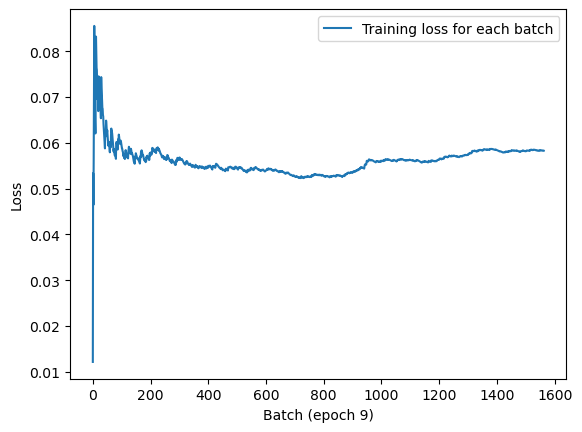

In [99]:
model = get_mnist_model()
model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)
model.fit(
    train_images,
    train_labels,
    epochs=10,
    callbacks=[LossHistory()],
    validation_data=(val_images, val_labels),
)

그림 7.5와 같은 그래프를 얻게 됩니다.

<img src="https://deeplearningwithpython.io/images/ch07/loss_history_callback_example.1e42f6b2.png" width="600"><p style="text-align:center">Figure 7.5: The output of our custom history-plotting callback</p>

#### Monitoring and visualization with TensorBoard

훌륭한 연구를 수행하거나 좋은 모델을 개발하려면 실험 중에 모델 내부에서 무슨 일이 일어나고 있는지에 대한 풍부하고 빈번한 피드백이 필요합니다. 실험을 실행하는 목적은 바로 모델의 성능에 대한 정보를 최대한 많이 얻는 것입니다. 발전은 반복적인 과정, 즉 루프입니다. 아이디어에서 시작하여 이를 실험으로 구현하고 아이디어를 검증하거나 반증하려고 시도합니다. 그림 7.6에서처럼 이 실험을 실행하고 생성된 정보를 처리합니다. 이 정보는 다음 아이디어에 영감을 줍니다. 이 루프를 더 많이 반복할수록 아이디어는 더욱 정교해지고 강력해집니다. Keras는 아이디어에서 실험까지 최소한의 시간으로 진행할 수 있도록 도와주고, 빠른 GPU는 실험에서 결과까지 최대한 빠르게 도달할 수 있도록 도와줍니다. 그렇다면 실험 결과를 처리하는 방법은 무엇일까요? 바로 TensorBoard가 필요한 부분입니다.
<img src="https://deeplearningwithpython.io/images/ch07/the_loop_of_progress.df126e89.png" width="600"><p style="text-align:center">Figure 7.6: The loop of progress</p>

그림 7.6: 발전의 루프
TensorBoard는 로컬에서 실행할 수 있는 브라우저 기반 애플리케이션입니다. 학습 중에 모델 내부에서 일어나는 모든 일을 모니터링하는 가장 좋은 방법입니다. TensorBoard를 사용하면 다음과 같은 작업을 수행할 수 있습니
* 학습 중 메트릭을 시각적으로 모니터링
* 모델 아키텍처 시각화
* 활성화 및 기울기 히스토그램 시각화
* 임베딩을 3D로 탐색

모델의 최종 손실뿐만 아니라 더 많은 정보를 모니터링하면 모델의 동작과 한계를 더 명확하게 파악하고 학습 속도를 높일 수 있습니다.
 수 있습니다.

Keras 모델과 `fit()` 메서드에서 TensorBoard를 사용하는 가장 쉬운 방법은 `keras.callbacks.TensorBoard` 콜백을 사용하는 것입니다. 가장 간단한 경우, 콜백이 로그를 기록할 위치만 지정하면 됩니다.

In [102]:
model = get_mnist_model()
model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)

tensorboard = keras.callbacks.TensorBoard(
    log_dir="/full_path_to_your_log_dir",
)
model.fit(
    train_images,
    train_labels,
    epochs=10,
    validation_data=(val_images, val_labels),
    callbacks=[tensorboard],
)

Epoch 1/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9136 - loss: 0.2910 - val_accuracy: 0.9596 - val_loss: 0.1456
Epoch 2/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.9542 - loss: 0.1485 - val_accuracy: 0.9695 - val_loss: 0.1023
Epoch 3/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9641 - loss: 0.1146 - val_accuracy: 0.9730 - val_loss: 0.0883
Epoch 4/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9694 - loss: 0.0976 - val_accuracy: 0.9754 - val_loss: 0.0781
Epoch 5/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9726 - loss: 0.0866 - val_accuracy: 0.9765 - val_loss: 0.0805
Epoch 6/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9756 - loss: 0.0750 - val_accuracy: 0.9778 - val_loss: 0.0758
Epoch 7/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9777 - loss: 0.0697 - val_accuracy: 0.9793 - val_loss: 0.0733
Epoch 8/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9794 - loss: 0.0638 - 

모델 실행이 시작되면 지정된 위치에 로그가 기록됩니다. 로컬 머신에서 Python 스크립트를 실행하는 경우 다음 명령을 사용하여 로컬 TensorBoard 서버를 시작할 수 있습니다(TensorFlow를 pip를 통해 설치했다면 tensorboard 실행 파일이 이미 있어야 합니다. 그렇지 않은 경우 pip install tensorboard 명령을 사용하여 TensorBoard를 수동으로 설치할 수 있습니다).

명령이 반환하는 URL로 이동하면 TensorBoard 인터페이스에 액세스할 수 있습니다.

스크립트를 Colab 노트북에서 실행하는 경우 다음 명령을 사용하여 노트북의 일부로 내장 TensorBoard 인스턴스를 실행할 수 있습니다.

In [105]:
%load_ext tensorboard
%tensorboard --logdir /full_path_to_your_log_dir

Reusing TensorBoard on port 6006 (pid 34860), started 0:30:29 ago. (Use '!kill 34860' to kill it.)

TensorBoard 인터페이스에서는 그림 7.7에서 보는 것처럼 학습 및 평가 지표의 실시간 그래프를 모니터링할 수 있습니다.

<img src="https://deeplearningwithpython.io/images/ch07/tensorboard.aec6cc75.png" width="600"><p style="text-align:center">Figure 7.7: TensorBoard can be used for easy monitoring of training and evaluation metrics.</p>

### Writing your own training and evaluation loops

`fit()` 워크플로는 사용 편의성과 유연성 사이에서 훌륭한 균형을 이루고 있습니다. 대부분의 경우 이 워크플로를 사용하게 될 것입니다. 하지만 이 워크플로는 딥러닝 연구자가 원하는 모든 기능을 지원하도록 설계된 것은 아닙니다. 사용자 정의 메트릭, 손실 함수, 콜백 함수 등을 사용하더라도 마찬가지입니다.

기본 제공되는 `fit()` 워크플로는 오로지 지도 학습에만 초점을 맞추고 있습니다. 지도 학습은 입력 데이터와 연결된 알려진 목표값(레이블 또는 어노테이션이라고도 함)이 있고, 손실 함수를 이러한 목표값과 모델의 예측값의 함수로 계산하는 방식입니다. 그러나 모든 머신러닝이 이 범주에 속하는 것은 아닙니다. 생성 학습(16장에서 소개), 자기 지도 학습(입력 데이터로부터 목표값을 얻는 방식), 강화 학습(강아지 훈련처럼 간헐적인 "보상"을 통해 학습하는 방식)과 같이 명시적인 목표값이 없는 경우도 있습니다. 또한 일반적인 지도 학습을 수행하더라도 연구자는 저수준의 유연성이 필요한 새로운 기능을 추가하고 싶을 수 있습니다.

내장 함수 `fit()`만으로는 충분하지 않은 상황에 직면할 때는 직접 사용자 지정 학습 로직을 작성해야 합니다. 2장과 3장에서 이미 간단한 저수준 학습 루프 예제를 살펴보았습니다. 일반적인 학습 루프의 내용은 다음과 같습니다.

현재 데이터 배치에 대한 손실 값을 얻기 위해 "순방향 전달"(모델 출력 계산)을 실행합니다.

모델 가중치에 대한 손실의 기울기를 계산합니다.

현재 데이터 배치의 손실 값을 낮추도록 모델의 가중치를 업데이트합니다.

이러한 단계는 필요한 만큼의 배치에 대해 반복됩니다. 이것이 바로 `fit()` 함수가 내부적으로 수행하는 작업입니다. 이 섹션에서는 `fit()` 함수를 처음부터 다시 구현하는 방법을 배우게 되며, 이를 통해 어떤 학습 알고리즘이든 직접 작성할 수 있는 지식을 얻게 될 것입니다.

자세한 내용을 살펴보겠습니다. 다음 몇 섹션에 걸쳐 TensorFlow, PyTorch 및 JAX를 사용하여 완전한 기능을 갖춘 맞춤형 학습 루프를 작성하는 단계까지 진행하게 됩니다.

#### Training vs. inference

지금까지 살펴본 저수준 학습 루프 예제에서 1단계(순방향 전달)는 `predictions = model(inputs)`를 통해 수행되었고, 2단계(그래디언트 테이프에서 계산된 그래디언트를 가져오는 것)는 백엔드별 API를 통해 수행되었습니다. 예를 들어 다음과 같습니다.

* TensorFlow: `gradients = tape.gradient(loss, model.weights)`
* PyTorch: `loss.backward()`
* JAX: `jax.value_and_grad()`

일반적인 경우에는 고려해야 할 두 가지 미묘한 차이가 있습니다.

Dropout 레이어와 같은 일부 Keras 레이어는 학습 중과 추론(예측을 생성하는 데 사용) 중에 동작 방식이 다릅니다. 이러한 레이어는 `call()` 메서드에 `training`이라는 부울 인수를 제공합니다. `dropout(inputs, training=True)`를 호출하면 일부 활성화 항목이 제거되고, `dropout(inputs, training=False)`를 호출하면 아무 작업도 수행되지 않습니다. 마찬가지로 함수형 모델과 순차형 모델도 `call()` 메서드에 이 `training` 인수를 제공합니다. Keras 모델을 순방향 전달(forward pass) 중에 호출할 때는 `training=True`를 반드시 전달해야 합니다! 따라서 순방향 전달 코드는 `predictions = model(inputs, training=True)`가 됩니다.

또한, 모델 가중치의 기울기를 가져올 때는 `model.weights`가 아닌 `model.trainable_weights`를 사용해야 합니다. 레이어와 모델은 두 가지 종류의 가중치를 가집니다.

* 첫째, 역전파를 통해 모델의 손실을 최소화하도록 업데이트되는 학습 가능 가중치(trainable weights)입니다. 예를 들어, Dense 레이어의 커널과 바이어스가 여기에 해당합니다.

* 둘째, 순방향 전달 중에 해당 레이어에서 업데이트되는 학습 불가능 가중치(non-trainable weights)입니다. 예를 들어, 특정 레이어가 지금까지 처리한 배치 수를 카운터로 저장하려면, 이 정보는 학습 불가능 가중치에 저장되고, 각 배치마다 레이어는 카운터를 1씩 증가시킵니다.

케라스 내장 레이어 중 학습 불가능한 가중치를 사용하는 유일한 레이어는 9장에서 소개할 배치 정규화(BatchNormalization) 레이어입니다. 배치 정규화 레이어는 통과하는 데이터의 평균과 표준 편차에 대한 정보를 추적하기 위해 학습 불가능한 가중치가 필요하며, 이를 통해 특징 정규화(4장과 6장에서 배운 개념)를 온라인으로 근사화합니다.

#### Writing custom training step functions

이 두 가지 사항을 고려하면 지도 학습 훈련 단계는 의사 코드로 다음과 같이 표현됩니다.

In [110]:
def train_step(inputs, targets):
    # Runs the forward pass
    predictions = model(inputs, training=True)
    # Computes the loss for the current batch
    loss = loss_fn(targets, predictions)
    # Retrieves the gradients of the loss with regard to the model's
    # trainable weights This function doesn't actually exist!
    gradients = get_gradients_of(loss, wrt=model.trainable_weights)
    # Updates the model's trainable weights based on the gradients
    optimizer.apply(gradients, model.trainable_weights)

이 코드 조각은 가상의 함수 `get_gradients_of()`를 포함하고 있기 때문에 실제 코드가 아닌 의사 코드입니다. 실제로는 기울기를 가져오는 방식은 사용하는 백엔드(JAX, TensorFlow 또는 PyTorch)에 따라 다릅니다.

이제 3장에서 각 프레임워크에 대해 배운 내용을 바탕으로 `train_step()` 함수의 실제 버전을 구현해 보겠습니다. TensorFlow와 PyTorch는 비교적 쉽게 구현할 수 있으므로 이 두 프레임워크부터 시작하는 것이 좋습니다. 마지막으로 좀 더 복잡한 JAX를 다뤄보겠습니다.

##### A TensorFlow training step function

TensorFlow를 사용하면 저희가 제시한 의사 코드 조각과 거의 유사한 코드를 작성할 수 있습니다. 유일한 차이점은 순방향 전달이 GradientTape 스코프 내에서 이루어져야 한다는 것입니다. 그런 다음 테이프 객체를 사용하여 기울기를 가져올 수 있습니다.

In [115]:
import tensorflow as tf

model = get_mnist_model()
loss_fn = keras.losses.SparseCategoricalCrossentropy()
optimizer = keras.optimizers.Adam()

def train_step(inputs, targets):
    with tf.GradientTape() as tape:
        predictions = model(inputs, training=True)
        loss = loss_fn(targets, predictions)
    gradients = tape.gradient(loss, model.trainable_weights)
    optimizer.apply(gradients, model.trainable_weights)
    return loss

한 단계만 실행해 보겠습니다.

In [120]:
batch_size = 32
inputs = train_images[:batch_size]
targets = train_labels[:batch_size]
loss = train_step(inputs, targets)

##### A PyTorch training step function

PyTorch 백엔드를 사용하면 모든 Keras 레이어와 모델은 PyTorch의 `torch.nn.Module` 클래스를 상속받고 네이티브 모듈 API를 노출합니다. 결과적으로 모델, 학습 가능한 가중치, 손실 텐서는 모두 서로를 인식하고 `loss.backward()`, `weight.value.grad`, `model.zero_grad()`라는 세 가지 메서드를 통해 상호 작용합니다.

3장에서 설명했듯이, 기억해야 할 핵심 모델은 다음과 같습니다.

PyTorch는 순방향 전달을 할 때마다 방금 수행된 계산을 추적하는 일회성 계산 그래프를 구축합니다.

이 그래프의 특정 스칼라 노드(예: 손실 텐서)에서 `.backward()`를 호출하면 해당 노드에서 시작하여 그래프를 역방향으로 실행하고, 관련된 모든 텐서(requires_grad=True인 경우)에 출력 노드의 기울기를 나타내는 `tensor.grad` 속성을 자동으로 채웁니다. 특히 학습 가능한 매개변수의 `grad` 속성이 채워집니다.

텐서의 `tensor.grad` 속성 내용을 지우려면 모든 텐서에 대해 `tensor.grad = None`을 호출해야 합니다. 모든 모델 변수에 대해 개별적으로 이 작업을 수행하는 것은 다소 번거롭기 때문에 `model.zero_grad()`를 통해 모델 수준에서 한 번에 처리할 수 있습니다. `zero_grad()` 호출은 모델이 추적하는 모든 변수에 적용됩니다. `backward()` 호출은 가산 방식으로 이루어지기 때문에 기울기를 지우는 것은 매우 중요합니다. 각 단계에서 기울기를 지우지 않으면 기울기 값이 누적되어 학습이 진행되지 않습니다.
이제 이러한 단계를 순서대로 진행해 보겠습니다.

In [125]:
import torch

model = get_mnist_model()
loss_fn = keras.losses.SparseCategoricalCrossentropy()
optimizer = keras.optimizers.Adam()

def train_step(inputs, targets):
    # Runs the forward pass
    predictions = model(inputs, training=True)
    loss = loss_fn(targets, predictions)
    # Runs the backward pass, populating gradient values
    loss.backward()
    # Recovers the gradient associated with each trainable variable.
    # That weight.value is the PyTorch tensor that contains the
    # variable's value.
    gradients = [weight.value.grad for weight in model.trainable_weights]
    # Updates the model's trainable weights based on the gradients.
    # This must be done in a no_grad() scope.
    with torch.no_grad():
        optimizer.apply(gradients, model.trainable_weights)
    # Don't forget to clear the gradients!
    model.zero_grad()
    return loss

ModuleNotFoundError: No module named 'torch'

한 단계만 실행해 보겠습니다.

In [ ]:
%%backend torch
batch_size = 32
inputs = train_images[:batch_size]
targets = train_labels[:batch_size]
loss = train_step(inputs, targets)

##### A JAX training step function

저수준 학습 코드 작성에 있어서 JAX는 완전한 상태 비저장 특성 때문에 세 가지 백엔드 중 가장 복잡한 경향이 있습니다. 상태 비저장 특성 덕분에 JAX는 높은 성능과 확장성을 제공하며, 컴파일 및 자동 성능 최적화에 적합합니다. 하지만 상태 비저장 코드를 작성하려면 몇 가지 단계를 거쳐야 합니다.

기울기 함수는 메타프로그래밍을 통해 얻어지므로, 먼저 손실 값을 반환하는 함수를 정의해야 합니다. 또한, 이 함수는 상태를 저장하지 않아야 하므로 사용할 모든 변수를 인수로 받아야 하고, 업데이트된 변수의 값을 반환해야 합니다. 순방향 전달 과정에서 수정될 수 있는 학습 불가능한 가중치들을 기억하시나요? 바로 이러한 변수들을 반환해야 합니다.

JAX의 상태 비저장 프로그래밍 패러다임을 더 쉽게 사용할 수 있도록 Keras 모델은 상태 비저장 순방향 전달 메서드인 `stateless_call()`을 제공합니다. 이 메서드는 `__call__` 메서드와 동작 방식이 동일하지만, 다음과 같은 차이점이 있습니다.

* 입력값으로 모델의 학습 가능 가중치와 학습 불가능 가중치, 그리고 입력값과 학습 인자를 받습니다.

* 반환값으로는 모델의 출력값과 함께 업데이트된 학습 불가능 가중치를 반환합니다.

작동 방식은 다음과 같습니다.

In [ ]:
outputs, non_trainable_weights = model.stateless_call(
    trainable_weights, non_trainable_weights, inputs
)

stateless_call()을 사용하여 JAX 손실 함수를 구현할 수 있습니다. 손실 함수는 학습 불가능한 모든 변수에 대한 업데이트도 계산하므로 compute_loss_and_updates()라고 이름을 지정합니다.

In [129]:
model = get_mnist_model()
loss_fn = keras.losses.SparseCategoricalCrossentropy()

# Gradients are computed for the entries in the first argument
# (trainable_variables here)
def compute_loss_and_updates(
    trainable_variables, non_trainable_variables, inputs, targets
):
    # Calls stateless_call
    outputs, non_trainable_variables = model.stateless_call(
        trainable_variables, non_trainable_variables, inputs, training=True
    )
    loss = loss_fn(targets, outputs)
    # Returns the scalar loss value and the updated non-trainable
    # weights
    return loss, non_trainable_variables

compute_loss_and_updates() 함수를 얻은 후에는 이 함수를 jax.value_and_grad에 전달하여 기울기 계산 결과를 얻을 수 있습니다.

```
import jax

grad_fn = jax.value_and_grad(fn)
loss, gradients = grad_fn(.
```
자, 이제 작은 문제가 하나 있습니다. jax.grad()와 jax.value_and_grad() 모두 fn이 스칼라 값만 반환해야 합니다. compute_loss_and_updates() 함수는 첫 번째 출력으로 스칼라 값을 반환하지만, 학습 불가능한 가중치에 대한 새로운 값도 함께 반환합니다. 3장에서 배운 내용을 기억하시나요? 해결책은 grad() 또는 value_and_grad() 함수에 has_aux 인수를 전달하는 것입니다. 다음과 같이 하면 됩니다...)

In [131]:
import jax

grad_fn = jax.value_and_grad(compute_loss_and_updates, has_aux=True)

ModuleNotFoundError: No module named 'jax'

사용 방법은 다음과 같습니다.
```
(loss, non_trainable_weights), gradients = grad_fn(
    trainable_variables, non_trainable_variables, inputs, targets
```
네, 지금까지 JAX 관련 내용이 많았지만, 이제 JAX 학습 단계를 구성하는 데 필요한 거의 모든 것을 갖췄습니다. 마지막으로 필요한 것은 optimizer.apply()입니다.

2장 초반에 TensorFlow로 첫 번째 기본 학습 단계를 작성했을 때, 다음과 같은 업데이트 단계 함수를 작성했었죠.
)

In [ ]:
learning_rate = 1e-3

def update_weights(gradients, weights):
    for g, w in zip(gradients, weights):
        w.assign(w - g * learning_rate)

이는 `keras.optimizers.SGD` 옵티마이저가 수행하는 작업과 유사합니다. 하지만 Keras API의 다른 모든 옵티마이저는 이보다 다소 복잡하며 학습 속도를 높이는 데 도움이 되는 보조 변수를 추적합니다. 특히 대부분의 옵티마이저는 2장에서 다룬 모멘텀 개념을 사용합니다. 이러한 추가 변수는 학습의 각 단계에서 업데이트되며, JAX 환경에서는 이러한 변수를 인수로 받아 새로운 값을 반환하는 상태 비저장 함수가 필요합니다.

이를 쉽게 하기 위해 Keras는 모든 옵티마이저에서 `stateless_apply()` 메서드를 제공합니다. 이 메서드는 다음과 같이 작동합니다.

In [ ]:
trainable_variables, optimizer_variables = optimizer.stateless_apply(
    optimizer_variables, grads, trainable_variables
)

이제 우리는 완벽한 교육 과정을 구성하는 데 필요한 모든 것을 갖추었습니다.

In [ ]:
%%backend jax
optimizer = keras.optimizers.Adam()
optimizer.build(model.trainable_variables)

# The state is part of the function arguments.
def train_step(state, inputs, targets):
    # Unpacks the state
    (trainable_variables, non_trainable_variables, optimizer_variables) = state
    # Computes gradients and updates to non-trainable variables
    (loss, non_trainable_variables), grads = grad_fn(
        trainable_variables, non_trainable_variables, inputs, targets
    )
    # Updates trainable variables and optimizer variables
    trainable_variables, optimizer_variables = optimizer.stateless_apply(
        optimizer_variables, grads, trainable_variables
    )
    return loss, (
        # Returns the updated state alongside the loss
        trainable_variables,
        non_trainable_variables,
        optimizer_variables,
    )

한 단계만 실행해 보겠습니다.

In [ ]:
%%backend jax
batch_size = 32
inputs = train_images[:batch_size]
targets = train_labels[:batch_size]

trainable_variables = [v.value for v in model.trainable_variables]
non_trainable_variables = [v.value for v in model.non_trainable_variables]
optimizer_variables = [v.value for v in optimizer.variables]

state = (trainable_variables, non_trainable_variables, optimizer_variables)
loss, state = train_step(state, inputs, targets)

TensorFlow나 PyTorch보다 확실히 작업량이 조금 더 많지만, JAX의 속도와 확장성이라는 장점이 그 단점을 충분히 상쇄합니다.

다음으로, 사용자 지정 학습 루프의 또 다른 중요한 요소인 메트릭에 대해 살펴보겠습니다.

#### Low-level usage of metrics

저수준 학습 루프에서는 Keras 메트릭(사용자 정의 메트릭이든 내장 메트릭이든)을 사용하는 것이 좋습니다. 메트릭 API에 대해서는 이미 배웠습니다. 각 목표 및 예측 배치에 대해 update_state(y_true, y_pred)를 호출하고 result()를 사용하여 현재 메트릭 값을 조회하면 됩니다.

In [133]:
from keras import ops

metric = keras.metrics.SparseCategoricalAccuracy()
targets = ops.array([0, 1, 2])
predictions = ops.array([[1, 0, 0], [0, 1, 0], [0, 0, 1]])
metric.update_state(targets, predictions)
current_result = metric.result()
print(f"result: {current_result:.2f}")

result: 1.00


모델의 손실과 같은 스칼라 값의 평균을 추적해야 할 수도 있습니다. 이 경우 `keras.metrics.Mean` 메트릭을 사용하면 됩니다.

In [136]:
values = ops.array([0, 1, 2, 3, 4])
mean_tracker = keras.metrics.Mean()
for value in values:
    mean_tracker.update_state(value)
print(f"Mean of values: {mean_tracker.result():.2f}")

Mean of values: 2.00


학습 에포크 시작 시 또는 평가 시작 시 현재 결과를 초기화하려면 `metric.reset_state()`를 사용하는 것을 잊지 마세요.

JAX를 사용하는 경우 `update_state()` 또는 `reset()`과 같은 상태 수정 메서드는 스테이트리스 함수 내에서 사용할 수 없습니다. 대신, 이전에 학습한 `model.stateless_call()` 및 `optimizer.stateless_apply()` 메서드와 유사한 스테이트리스 메트릭 API를 사용할 수 있습니다. 작동 방식은 다음과 같습니다.

In [139]:
metric = keras.metrics.SparseCategoricalAccuracy()
targets = ops.array([0, 1, 2])
predictions = ops.array([[1, 0, 0], [0, 1, 0], [0, 0, 1]])

metric_variables = metric.variables
metric_variables = metric.stateless_update_state(
    metric_variables, targets, predictions
)
current_result = metric.stateless_result(metric_variables)
print(f"result: {current_result:.2f}")

metric_variables = metric.stateless_reset_state()

result: 1.00


#### Using fit() with a custom training loop

이전 섹션에서는 학습 로직을 처음부터 직접 작성했습니다. 이렇게 하면 가장 큰 유연성을 얻을 수 있지만, 많은 코드를 작성해야 할 뿐만 아니라 `fit()`의 콜백, 성능 최적화, 분산 학습 지원과 같은 편리한 기능을 활용할 수 없게 됩니다.

사용자 지정 학습 알고리즘이 필요하지만 Keras의 내장 학습 루프 기능도 사용하고 싶다면 어떻게 해야 할까요? `fit()`과 직접 작성한 학습 루프 사이에는 중간 지점이 있습니다. 바로 사용자 지정 학습 단계 함수를 제공하고 프레임워크가 나머지를 처리하도록 하는 것입니다.

이는 `Model` 클래스의 `train_step()` 메서드를 오버라이드하여 구현할 수 있습니다. 이 함수는 `fit()`이 데이터 배치마다 호출하는 함수입니다. 이렇게 하면 평소처럼 `fit()`을 호출할 수 있으며, 내부적으로는 사용자 지정 학습 알고리즘이 실행됩니다.

작동 방식은 다음과 같습니다.

* `keras.Model`을 상속하는 새 클래스를 생성합니다.

* `train_step()` 메서드를 오버라이드합니다.` 내용은 이전 섹션에서 사용한 것과 거의 동일합니다.
* 메트릭 이름(손실 포함)과 현재 값을 매핑하는 딕셔너리를 반환합니다.

다음 사항에 유의하세요.

* 이 패턴은 함수형 API를 사용하여 모델을 구축하는 것을 막지 않습니다. 순차 모델, 함수형 API 모델 또는 서브클래싱된 모델을 구축하는 경우 모두 가능합니다.
* train_step()을 재정의할 때 @tf.function 또는 @jax.jit 데코레이터를 사용할 필요가 없습니다. 프레임워크에서 자동으로 처리해 줍니다.

##### Customizing fit() with TensorFlow
먼저 사용자 정의 TensorFlow 학습 단계를 코딩해 보겠습니다.

In [145]:
import keras
from keras import layers

loss_fn = keras.losses.SparseCategoricalCrossentropy()
# This metric object will be used to track the average of per-batch
# losses during training and evaluation.
loss_tracker = keras.metrics.Mean(name="loss")

class CustomModel(keras.Model):
    # Overrides the train_step() method
    def train_step(self, data):
        inputs, targets = data
        with tf.GradientTape() as tape:
            # We use self(inputs, training=True) instead of
            # model(inputs, training=True) since our model is the class
            # itself.
            predictions = self(inputs, training=True)
            loss = loss_fn(targets, predictions)
        gradients = tape.gradient(loss, self.trainable_weights)
        self.optimizer.apply(gradients, self.trainable_weights)

        # Updates the loss tracker metric that tracks the average of
        # the loss
        loss_tracker.update_state(loss)
        # Returns the average loss so far by querying the loss tracker
        # metric
        return {"loss": loss_tracker.result()}

    # Listing the loss tracker metric in the model.metrics property
    # enables the model to automatically call reset_state() on it at
    # the start of each epoch and at the start of a call to evaluate()
    # — so you don't have to do it by hand. Any metric you would like
    # to reset across epochs should be listed here.
    @property
    def metrics(self):
        return [loss_tracker]

이제 사용자 정의 모델을 인스턴스화하고 컴파일할 수 있습니다(손실 함수는 모델 외부에서 이미 정의되어 있으므로 옵티마이저만 전달합니다). 그런 다음 평소처럼 `fit()` 함수를 사용하여 학습시킬 수 있습니다.

이제 모델 정의를 재사용 가능한 별도의 함수로 만들어 보겠습니다.

In [148]:
def get_custom_model():
    inputs = keras.Input(shape=(28 * 28,))
    features = layers.Dense(512, activation="relu")(inputs)
    features = layers.Dropout(0.5)(features)
    outputs = layers.Dense(10, activation="softmax")(features)
    model = CustomModel(inputs, outputs)
    model.compile(optimizer=keras.optimizers.Adam())
    return model

한번 시도해 봅시다:

In [153]:
model = get_custom_model()
model.fit(train_images, train_labels, epochs=3)

Epoch 1/3
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.2932
Epoch 2/3
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.1471
Epoch 3/3
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.1151


##### Customizing fit() with PyTorch

다음은 PyTorch 버전입니다.

In [ ]:
%%backend torch
import keras
from keras import layers

loss_fn = keras.losses.SparseCategoricalCrossentropy()
loss_tracker = keras.metrics.Mean(name="loss")

class CustomModel(keras.Model):
    def train_step(self, data):
        inputs, targets = data
        # Runs the forward pass
        predictions = self(inputs, training=True)
        loss = loss_fn(targets, predictions)

        # Retrieves the gradients
        loss.backward()
        trainable_weights = [v for v in self.trainable_weights]
        gradients = [v.value.grad for v in trainable_weights]

        with torch.no_grad():
            # Updates weights
            self.optimizer.apply(gradients, trainable_weights)

        # Updates loss tracker metric
        loss_tracker.update_state(loss)
        # Returns the average loss so far by querying the loss tracker
        # metric
        return {"loss": loss_tracker.result()}

    @property
    def metrics(self):
        return [loss_tracker]

한번 해볼까요?

In [ ]:
%%backend torch
def get_custom_model():
    inputs = keras.Input(shape=(28 * 28,))
    features = layers.Dense(512, activation="relu")(inputs)
    features = layers.Dropout(0.5)(features)
    outputs = layers.Dense(10, activation="softmax")(features)
    model = CustomModel(inputs, outputs)
    model.compile(optimizer=keras.optimizers.Adam())
    return model

In [ ]:
%%backend torch
model = get_custom_model()
model.fit(train_images, train_labels, epochs=3)

##### Customizing fit() with JAX

마지막으로 JAX 버전을 작성해 보겠습니다. 먼저 사용자 지정 학습 단계 예제에서 사용했던 compute_loss_and_updates() 함수와 유사한 compute_loss_and_updates() 메서드를 정의해야 합니다.

In [ ]:
%%backend jax
import keras
from keras import layers

loss_fn = keras.losses.SparseCategoricalCrossentropy()

class CustomModel(keras.Model):
    def compute_loss_and_updates(
        self,
        trainable_variables,
        non_trainable_variables,
        inputs,
        targets,
        training=False,
    ):
        predictions, non_trainable_variables = self.stateless_call(
            trainable_variables,
            non_trainable_variables,
            inputs,
            training=training,
        )
        loss = loss_fn(targets, predictions)
        return loss, non_trainable_variables

    def train_step(self, state, data):
        (
            trainable_variables,
            non_trainable_variables,
            optimizer_variables,
            metrics_variables,
        ) = state
        inputs, targets = data

        grad_fn = jax.value_and_grad(
            self.compute_loss_and_updates, has_aux=True
        )

        (loss, non_trainable_variables), grads = grad_fn(
            trainable_variables,
            non_trainable_variables,
            inputs,
            targets,
            training=True,
        )

        (
            trainable_variables,
            optimizer_variables,
        ) = self.optimizer.stateless_apply(
            optimizer_variables, grads, trainable_variables
        )

        logs = {"loss": loss}
        state = (
            trainable_variables,
            non_trainable_variables,
            optimizer_variables,
            metrics_variables,
        )
        return logs, state

참고로, 다른 두 백엔드에서처럼 손실의 이동 평균을 계산하지 않습니다. 대신 배치별 손실 값을 반환하는데, 이는 유용성이 떨어집니다. 이렇게 하는 이유는 예제에서 메트릭 상태 관리를 단순화하기 위해서입니다. 메트릭 상태 관리를 포함하면 코드가 매우 장황해지기 때문입니다(메트릭 관리에 대해서는 다음 섹션에서 자세히 설명합니다).

In [ ]:
%%backend jax
def get_custom_model():
    inputs = keras.Input(shape=(28 * 28,))
    features = layers.Dense(512, activation="relu")(inputs)
    features = layers.Dropout(0.5)(features)
    outputs = layers.Dense(10, activation="softmax")(features)
    model = CustomModel(inputs, outputs)
    model.compile(optimizer=keras.optimizers.Adam())
    return model

In [ ]:
%%backend jax
model = get_custom_model()
model.fit(train_images, train_labels, epochs=3)

#### Handling metrics in a custom train_step()

마지막으로, compile() 함수에 전달할 수 있는 손실 함수와 메트릭은 무엇일까요? compile() 함수를 호출한 후에는 다음과 같은 값들을 사용할 수 있습니다.

* self.compute_loss — compile() 함수에 전달한 손실 함수와 특정 레이어에서 추가될 수 있는 정규화 손실을 합산한 값입니다.
* self.metrics — compile() 함수에 전달한 메트릭 목록입니다. 여기에는 손실을 추적하는 메트릭도 포함됩니다.

##### train_step() metrics handling with TensorFlow

TensorFlow를 사용하면 다음과 같습니다.

In [ ]:
%%backend tensorflow
import keras
from keras import layers

class CustomModel(keras.Model):
    def train_step(self, data):
        inputs, targets = data
        with tf.GradientTape() as tape:
            predictions = self(inputs, training=True)
            loss = self.compute_loss(y=targets, y_pred=predictions)

        gradients = tape.gradient(loss, self.trainable_weights)
        self.optimizer.apply(gradients, self.trainable_weights)

        for metric in self.metrics:
            if metric.name == "loss":
                metric.update_state(loss)
            else:
                metric.update_state(targets, predictions)

        return {m.name: m.result() for m in self.metrics}

In [ ]:
%%backend tensorflow
def get_custom_model():
    inputs = keras.Input(shape=(28 * 28,))
    features = layers.Dense(512, activation="relu")(inputs)
    features = layers.Dropout(0.5)(features)
    outputs = layers.Dense(10, activation="softmax")(features)
    model = CustomModel(inputs, outputs)
    model.compile(
        optimizer=keras.optimizers.Adam(),
        loss=keras.losses.SparseCategoricalCrossentropy(),
        metrics=[keras.metrics.SparseCategoricalAccuracy()],
    )
    return model

model = get_custom_model()
model.fit(train_images, train_labels, epochs=3)

##### train_step() metrics handling with PyTorch

PyTorch를 사용하면 어떻게 될까요? 코드 변경 사항은 완전히 동일합니다!

In [ ]:
%%backend torch
import keras
from keras import layers

class CustomModel(keras.Model):
    def train_step(self, data):
        inputs, targets = data
        predictions = self(inputs, training=True)
        loss = self.compute_loss(y=targets, y_pred=predictions)

        loss.backward()
        trainable_weights = [v for v in self.trainable_weights]
        gradients = [v.value.grad for v in trainable_weights]

        with torch.no_grad():
            self.optimizer.apply(gradients, trainable_weights)

        for metric in self.metrics:
            if metric.name == "loss":
                metric.update_state(loss)
            else:
                metric.update_state(targets, predictions)

        return {m.name: m.result() for m in self.metrics}

In [ ]:
%%backend torch
def get_custom_model():
    inputs = keras.Input(shape=(28 * 28,))
    features = layers.Dense(512, activation="relu")(inputs)
    features = layers.Dropout(0.5)(features)
    outputs = layers.Dense(10, activation="softmax")(features)
    model = CustomModel(inputs, outputs)
    model.compile(
        optimizer=keras.optimizers.Adam(),
        loss=keras.losses.SparseCategoricalCrossentropy(),
        metrics=[keras.metrics.SparseCategoricalAccuracy()],
    )
    return model

model = get_custom_model()
model.fit(train_images, train_labels, epochs=3)

##### train_step() metrics handling with JAX

마지막으로 JAX를 사용하면 어떻게 되는지 살펴보겠습니다. 우선 compute_loss_and_updates() 메서드에서 compute_loss()를 사용하여 compile()에 전달된 손실 함수를 호출할 수 있습니다.

In [ ]:
%%backend jax
import keras
from keras import layers

class CustomModel(keras.Model):
    def compute_loss_and_updates(
        self,
        trainable_variables,
        non_trainable_variables,
        inputs,
        targets,
        training=False,
    ):
        predictions, non_trainable_variables = self.stateless_call(
            trainable_variables,
            non_trainable_variables,
            inputs,
            training=training,
        )
        loss = self.compute_loss(y=targets, y_pred=predictions)
        return loss, (predictions, non_trainable_variables)

    def train_step(self, state, data):
        (
            trainable_variables,
            non_trainable_variables,
            optimizer_variables,
            metrics_variables,
        ) = state
        inputs, targets = data

        grad_fn = jax.value_and_grad(
            self.compute_loss_and_updates, has_aux=True
        )

        (loss, (predictions, non_trainable_variables)), grads = grad_fn(
            trainable_variables,
            non_trainable_variables,
            inputs,
            targets,
            training=True,
        )
        (
            trainable_variables,
            optimizer_variables,
        ) = self.optimizer.stateless_apply(
            optimizer_variables, grads, trainable_variables
        )

        new_metrics_vars = []
        logs = {}
        for metric in self.metrics:
            num_prev = len(new_metrics_vars)
            num_current = len(metric.variables)
            current_vars = metrics_variables[num_prev : num_prev + num_current]
            if metric.name == "loss":
                current_vars = metric.stateless_update_state(current_vars, loss)
            else:
                current_vars = metric.stateless_update_state(
                    current_vars, targets, predictions
                )
            logs[metric.name] = metric.stateless_result(current_vars)
            new_metrics_vars += current_vars

        state = (
            trainable_variables,
            non_trainable_variables,
            optimizer_variables,
            new_metrics_vars,
        )
        return logs, state

많은 정보였지만, 이제 여러분은 케라스를 사용하여 거의 모든 작업을 수행할 수 있을 만큼 충분한 지식을 갖추게 되었습니다!

### Summary

* Keras는 점진적 복잡성 공개 원칙에 기반한 다양한 워크플로우를 제공하며, 이 워크플로우들은 모두 원활하게 상호 운용됩니다.
* Sequential 클래스, Functional API 또는 Model 클래스의 서브클래싱을 통해 모델을 구축할 수 있습니다. 대부분의 경우 Functional API를 사용하게 됩니다.
* 모델을 학습하고 평가하는 가장 간단한 방법은 기본 fit() 및 evaluate() 메서드를 사용하는 것입니다.
* Keras 콜백은 fit() 호출 중에 모델을 모니터링하고 모델 상태에 따라 자동으로 작업을 수행하는 간단한 방법을 제공합니다.
* 또한, JAX, TensorFlow 또는 PyTorch와 같은 원하는 백엔드의 API를 사용하여 train_step() 메서드를 재정의함으로써 fit() 메서드의 동작을 완벽하게 제어할 수 있습니다.
* fit() 메서드 외에도 백엔드 네이티브 방식으로 처음부터 완전히 새로운 학습 루프를 직접 작성할 수도 있습니다. 이는 완전히 새로운 학습 알고리즘을 구현하는 연구자에게 유용합니다.